### Imports

In [2]:
import glob
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,models
from keras.layers import Dense,Flatten,BatchNormalization,Conv2D,MaxPooling2D, Dropout, GlobalAveragePooling2D,Activation
from keras.applications.vgg16 import VGG16

### Train and Val split using split_folder library

In [1]:
import splitfolders

splitfolders.ratio("D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\DATA", output="D:\E\DXAssignment\\trafficSignDetection\\temp\output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

#### Restructured TEST folder as test

In the test folder only images givem but they are not folderwise seperated.
To seperate them folderwise i write below code.

In [23]:
def create_folder_at_destination(dest_path,folder_name_list):
    for folder_name in folder_name_list:
        os.mkdir(os.path.join(dest_path,folder_name))
    dest_folder_paths = glob.glob(os.path.join(dest_path,'*'))
    return dest_folder_paths # will return list which contains path of destination folder

In [24]:
dest_paths = create_folder_at_destination('D:\E\DXAssignment\\trafficSignDetection\\temp\output\\test',os.listdir('D:\E\DXAssignment\\trafficSignDetection\\temp\output\\train'))
print(len(dest_paths))

58


In [28]:
for image in all_images[:]:
    folder_name = image.split('\\')[-1].split('_')[0][1:]
    if folder_name[0] == '0':
        folder_name = folder_name[1]
    dest_path = 'D:\E\DXAssignment\\trafficSignDetection\\temp\\test\\'+ folder_name + '\\' + image.split('\\')[-1]
    shutil.copy(image,dest_path)

### Creating Generator

#### Path of train val test

In [5]:
train_dir = 'D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\\train'
val_dir = 'D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\\val'
test_dir = 'D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test'

#### Generator

In [6]:
# Constants which are used below
BATCH_SIZE = 5
IMG_SIZE_DIM = 224

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE_DIM,IMG_SIZE_DIM)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE_DIM,IMG_SIZE_DIM)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE_DIM,IMG_SIZE_DIM)
)

# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
test_ds = test_ds.map(process)

Found 3313 files belonging to 58 classes.
Found 857 files belonging to 58 classes.
Found 1994 files belonging to 58 classes.


### Create Model VGG16

In [33]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(IMG_SIZE_DIM,IMG_SIZE_DIM,3)
)

58889256/58889256 [==============================] - 6s 0us/step


In [34]:
# Every layer after block5_conv1 is trainable...
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [35]:
# Adding few layers of our own to the VGG16 model.

from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,activation='softmax'))

In [36]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [37]:
from keras.callbacks import ModelCheckpoint
# checkpoint allow you to 
filepath="D:\E\DXAssignment\\trafficSignDetection\\bestModel\VGG16\\VGG16_100-{epoch:02d}-{val_accuracy:.2f}.hdf5" # where our model save.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [40]:
history = model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=callbacks_list)

Epoch 1/10


c:\Users\ipiyu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


663/663 [==============================] - ETA: 0s - loss: 3.8131 - accuracy: 0.1458
Epoch 1: val_accuracy improved from -inf to 0.18086, saving model to D:\E\DXAssignment\trafficSignDetection\bestModel\VGG16\VGG16_100-01-0.18.hdf5
663/663 [==============================] - 151s 226ms/step - loss: 3.8131 - accuracy: 0.1458 - val_loss: 5.1914 - val_accuracy: 0.1809
Epoch 2/10
663/663 [==============================] - ETA: 0s - loss: 2.8335 - accuracy: 0.2668
Epoch 2: val_accuracy improved from 0.18086 to 0.46324, saving model to D:\E\DXAssignment\trafficSignDetection\bestModel\VGG16\VGG16_100-02-0.46.hdf5
663/663 [==============================] - 144s 217ms/step - loss: 2.8335 - accuracy: 0.2668 - val_loss: 2.8622 - val_accuracy: 0.4632
Epoch 3/10
663/663 [==============================] - ETA: 0s - loss: 2.3476 - accuracy: 0.3489
Epoch 3: val_accuracy improved from 0.46324 to 0.61727, saving model to D:\E\DXAssignment\trafficSignDetection\bestModel\VGG16\VGG16_100-03-0.62.hdf5
663/66

In [43]:
model = models.load_model('D:\E\DXAssignment\\trafficSignDetection\\bestModel\VGG16\VGG16_100-10-0.83.hdf5')
# Load the best from where it saved  previously.

In [44]:
print("Evaluate on test data")
results = model.evaluate(test_ds,batch_size=5)
print("test loss, test acc:", results)

Evaluate on test data


c:\Users\ipiyu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


399/399 [==============================] - 48s 119ms/step - loss: 3.2335 - accuracy: 0.6018
test loss, test acc: [3.2335002422332764, 0.6018053889274597]


### Create another Model from scratch

In [46]:
inputShape =(100,100,3)
chanDim = -1
classes = 58

In [ ]:
model = Sequential()
model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# second set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

In [ ]:
# model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# "categorical_crossentropy"
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])


from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="D:\E\DXAssignment\\trafficSignDetection\\bestModel\scratch\Scratch-100-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_ds,epochs=2,validation_data=val_ds,callbacks=callbacks_list)


### Let's Rename the folders to their original name

In [9]:
images = glob.glob('D:\E\DXAssignment\\trafficSignDetection\\temp\\output\\val\*\*')
print(len(images))

857


In [65]:
test_dir = 'D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test'

In [66]:
sequence = []
for path in glob.glob(test_dir + '\\*'):
    sequence.append(int(path.split('\\')[-1]))
print(sequence) # print list which are the names of folder before we renames them.

[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 6, 7, 8, 9]


In [74]:
import pandas as pd

dataFrame = pd.read_csv(r'D:\E\DXAssignment\trafficSignDetection\labels.csv')
print(list(dataFrame.Name)) # reading Name column from labels.csv 

['Speed limit (5kmperh)', 'Speed limit (15kmperh)', 'Speed limit (30kmperh)', 'Speed limit (40kmperh)', 'Speed limit (50kmperh)', 'Speed limit (60kmperh)', 'Speed limit (70kmperh)', 'speed limit (80kmperh)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40kmperh)', 'Speed limit (50kmperh)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Steep descent', 'Steep ascent', 'Slow(china)', 'Go right or straight', 'Go left or straight', 'Rest Area', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Electric Haza

In [75]:

seq_dict = {}
seq_dict = seq_dict.fromkeys(sequence,0)
for no in sequence:
    seq_dict[no] = dataFrame.Name[no]
print(seq_dict) # creating dict where key is current folder name and value : label of that folder.

{0: 'Speed limit (5kmperh)', 1: 'Speed limit (15kmperh)', 10: 'Dont Go straight', 11: 'Dont Go Left', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 14: 'Dont overtake from Left', 15: 'No Uturn', 16: 'No Car', 17: 'No horn', 18: 'Speed limit (40kmperh)', 19: 'Speed limit (50kmperh)', 2: 'Speed limit (30kmperh)', 20: 'Go straight or right', 21: 'Go straight', 22: 'Go Left', 23: 'Go Left or right', 24: 'Go Right', 25: 'keep Left', 26: 'keep Right', 27: 'Roundabout mandatory', 28: 'watch out for cars', 29: 'Horn', 3: 'Speed limit (40kmperh)', 30: 'Bicycles crossing', 31: 'Uturn', 32: 'Road Divider', 33: 'Traffic signals', 34: 'Danger Ahead', 35: 'Zebra Crossing', 36: 'Bicycles crossing', 37: 'Children crossing', 38: 'Dangerous curve to the left', 39: 'Dangerous curve to the right', 4: 'Speed limit (50kmperh)', 40: 'Steep descent', 41: 'Steep ascent', 42: 'Slow(china)', 43: 'Go right or straight', 44: 'Go left or straight', 45: 'Rest Area', 46: 'ZigZag Curve', 47: 'Train Crossing', 48: 

In [22]:
seq_dict

{0: 'Speed limit (5km/h)',
 1: 'Speed limit (15km/h)',
 10: 'Dont Go straight',
 11: 'Dont Go Left',
 12: 'Dont Go Left or Right',
 13: 'Dont Go Right',
 14: 'Dont overtake from Left',
 15: 'No Uturn',
 16: 'No Car',
 17: 'No horn',
 18: 'Speed limit (40km/h)',
 19: 'Speed limit (50km/h)',
 2: 'Speed limit (30km/h)',
 20: 'Go straight or right',
 21: 'Go straight',
 22: 'Go Left',
 23: 'Go Left or right',
 24: 'Go Right',
 25: 'keep Left',
 26: 'keep Right',
 27: 'Roundabout mandatory',
 28: 'watch out for cars',
 29: 'Horn',
 3: 'Speed limit (40km/h)',
 30: 'Bicycles crossing',
 31: 'Uturn',
 32: 'Road Divider',
 33: 'Traffic signals',
 34: 'Danger Ahead',
 35: 'Zebra Crossing',
 36: 'Bicycles crossing',
 37: 'Children crossing',
 38: 'Dangerous curve to the left',
 39: 'Dangerous curve to the right',
 4: 'Speed limit (50km/h)',
 40: 'Steep descent',
 41: 'Steep ascent',
 42: 'Slow(china)',
 43: 'Go right or straight',
 44: 'Go left or straight',
 45: 'Rest Area',
 46: 'ZigZag Curve',

In [76]:
final_dataframe = pd.DataFrame(seq_dict.items()) # create DataFrame of Dict

In [77]:
final_dataframe.set_axis(['ClassId', 'Name'], axis='columns', inplace=True) # adding name of that column

C:\Users\ipiyu\AppData\Local\Temp\ipykernel_17104\1054906264.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  final_dataframe.set_axis(['ClassId', 'Name'], axis='columns', inplace=True)


In [78]:
final_dataframe.to_csv('D:\E\DXAssignment\streamlit\\final_labels.csv') # writing that dataframe to csv file.

In [83]:
test_folders = glob.glob(r'D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\val\*')

In [84]:
for test_folder in test_folders:
    shutil.move(test_folder,'\\'.join(test_folder.split('\\')[:-1])+'\\' + seq_dict[int(test_folder.split('\\')[-1])] + '_'+test_folder.split('\\')[-1])

### There are 4 folders which are empty so, we copy one image from train folder.

#### Checking which are the folders are empty of test

In [3]:
folder_list = glob.glob('D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test\*')
print(len(folder_list)) # how many total folders are there.

58


In [54]:
empty_folder_list = []
for folder in folder_list :
    if len(glob.glob(os.path.join(folder+'\*'))) == 0 :
        empty_folder_list.append(folder) # will print folder which are empty

In [55]:
print(empty_folder_list) # path of folders which are empty

['D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test\\18', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test\\19', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test\\33', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\test\\9']


#### Checking which are the folders are empty of test

In [85]:
folder_list = glob.glob(r'D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJDNamedFolder\test\*')
print(len(folder_list))

58


In [86]:
empty_folder_list = []
for folder in folder_list :
    if len(glob.glob(os.path.join(folder+'\*'))) == 0 :
        empty_folder_list.append(folder) # will print folder which are empty
print(empty_folder_list)

['D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJDNamedFolder\\test\\Dont Go straight or Right_9', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJDNamedFolder\\test\\Speed limit (40kmperh)_18', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJDNamedFolder\\test\\Speed limit (50kmperh)_19', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJDNamedFolder\\test\\Traffic signals_33']


In [57]:
# crate list of folder from i'll take one image to empty folder 
folder_number = []
for path in empty_folder_list:
    folder_number.append(path.split('\\')[-1])
print(folder_number) # return folder names of the 

['18', '19', '33', '9']


In [59]:
copy_from_folder_list = []
for folder_num in folder_number:
    copy_from_folder_list.append('D:\E\DXAssignment\\trafficSignDetection\\trafficDataStructured\\train\\'+folder_num)
print(copy_from_folder_list) # list of folder from which i'll copy one image and then copy it to destination folder

['D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\train\\18', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\train\\19', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\train\\33', 'D:\\E\\DXAssignment\\trafficSignDetection\\trafficDataStructured\\train\\9']


In [ ]:
def create_folder_at_destination(dest_path,folder_name_list):
    for folder_name in folder_name_list:
        os.mkdir(os.path.join(dest_path,folder_name))
    dest_folder_paths = glob.glob(os.path.join(dest_path,'*'))
    return dest_folder_paths # will return list which contains path of destination folder

In [62]:
# create folders at destination using folder number so we can replace empty folders with this filled folder in future wherever we need.
for folder_n in folder_number:
    os.mkdir(os.path.join('D:\E\DXAssignment\\trafficSignDetection\empty_folders_filled\\'+folder_n))

In [64]:
# destination folder list
dest_folder_list = glob.glob('D:\E\DXAssignment\\trafficSignDetection\empty_folders_filled\*')
print(dest_folder_list)

['D:\\E\\DXAssignment\\trafficSignDetection\\empty_folders_filled\\18', 'D:\\E\\DXAssignment\\trafficSignDetection\\empty_folders_filled\\19', 'D:\\E\\DXAssignment\\trafficSignDetection\\empty_folders_filled\\33', 'D:\\E\\DXAssignment\\trafficSignDetection\\empty_folders_filled\\9']


In [76]:
# dest_folder_list where we copy atleast one image from copy_from_folder_list
for index in range(len(folder_number)):
    shutil.copy(glob.glob(os.path.join(copy_from_folder_list[index]+'\\*'))[0],dest_folder_list[index])
print('done')

done


### Splitting Data from DATA --> Train1(0.80) and Val(0.20)
### Then TEST --> Train2(0.75) and test(0.25)
### Then merge Train1 + Train2 ==> Train
### so finally we will have Train, val, test

In [56]:
# we will use TraficDataRestructuredAsJD as source

# 1. DATA --> Train(0.8) and Val(0.2)

import splitfolders

splitfolders.ratio("D:\E\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJD\DATA",
            output="D:\E\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJD\DATAR",
            seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

In [57]:
# 2. TEST --> Train2(0.75) and test(0.25)

import splitfolders

splitfolders.ratio("D:\E\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJD\TEST",
            output="D:\E\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJD\TESTR",
            seed=1337, ratio=(.75, .25), group_prefix=None, move=False)

In [58]:
#3. merge Train1 + Train2 ==> Train_final

folder_list_train1 = glob.glob('D:\E\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJD\DATAR\\train\*')
folder_list_train2 = glob.glob('D:\E\DXAssignment\\trafficSignDetection\\trafficDataRestructuredAsJD\TESTR\\train\*')
print(len(folder_list_train1))
print(len(folder_list_train2))

58
58


In [59]:
for index in range(len(folder_list_train1)):
    src_paths = glob.glob(os.path.join(folder_list_train2[index]+'\*'))
    for src_path in src_paths:
        print(src_path)
        try:
            shutil.move(src_path,folder_list_train1[index])
        except:
            l = src_path.split('\\')[:-1]
            half_string = '\\'.join(l) + '\\'
            full_path = half_string + src_path.split('\\')[-1].split('.')[0] + 'q.png'
            shutil.move(src_path,full_path) # renaming file whose name already exist at destination
            shutil.move(full_path,folder_list_train1[index]) # moving renamed file to destination


    # print(src_paths)

D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_0001_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_0002_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_0003_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_0004_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_0005_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_0007_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_1_0001_1_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_1_0004_1_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_1_0006_1_j.png
D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJD\TESTR\train\0\000_1_0007_1_j.png
D:\E\DXAssignment\traffi

### Create ImageDataGenerator

In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [89]:
# Constants which are used below
BATCH_SIZE = 5
IMG_SIZE_DIM = 150

In [92]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [100]:
test_dir = r'D:\E\DXAssignment\trafficSignDetection\trafficDataRestructuredAsJDNamedFolder\test'

In [93]:
test_ds = test_datagen.flow_from_directory(
        directory = test_dir,
        target_size = (IMG_SIZE_DIM,IMG_SIZE_DIM),
        batch_size = BATCH_SIZE,
        class_mode="sparse",
        shuffle=False,
        seed=42)

Found 517 images belonging to 58 classes.


In [87]:
model = models.load_model(r'D:\E\DXAssignment\streamlit\trafficSignClassification\bestModels\VGG16_150-40-0.96_sparse.hdf5')

In [94]:
predictions = model.predict(x=test_ds, verbose=0)

### let's create confusion matrix

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# %matplotlib inline

In [101]:
cm = confusion_matrix(y_true=test_ds.classes, y_pred=np.argmax(predictions, axis=-1))

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [109]:
fin_dict = test_ds.class_indices

In [114]:
name_of_classes = []
for class_name in fin_dict.keys():
    name_of_classes.append(class_name)
print(name_of_classes)

['Bicycles crossing_30', 'Bicycles crossing_36', 'Children crossing_37', 'Danger Ahead_34', 'Dangerous curve to the left_38', 'Dangerous curve to the right_39', 'Dont Go Left or Right_12', 'Dont Go Left_11', 'Dont Go Right_13', 'Dont Go straight or Right_9', 'Dont Go straight or left_8', 'Dont Go straight_10', 'Dont overtake from Left_14', 'Electric Hazard_49', 'Fences_50', 'Give Way_53', 'Give Way_56', 'Go Left or right_23', 'Go Left_22', 'Go Right_24', 'Go left or straight_44', 'Go right or straight_43', 'Go straight or right_20', 'Go straight_21', 'Heavy Vehicle Accidents_51', 'Horn_29', 'No Car_16', 'No Uturn_15', 'No entry_55', 'No horn_17', 'No stopping_54', 'Passing Without stopping_57', 'Rest Area_45', 'Road Divider_32', 'Roundabout mandatory_27', 'Slow(china)_42', 'Speed limit (15kmperh)_1', 'Speed limit (30kmperh)_2', 'Speed limit (40kmperh)_18', 'Speed limit (40kmperh)_3', 'Speed limit (50kmperh)_19', 'Speed limit (50kmperh)_4', 'Speed limit (5kmperh)_0', 'Speed limit (60kmp

In [99]:
def cal_accuracy(mat):
  sum = 0
  for i in range(len(mat[0])):
      sum = sum + mat[i][i]
  print(str((sum/250)*100)+"% Accuracy in confusion matrix")

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.85714286 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.92307692 0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


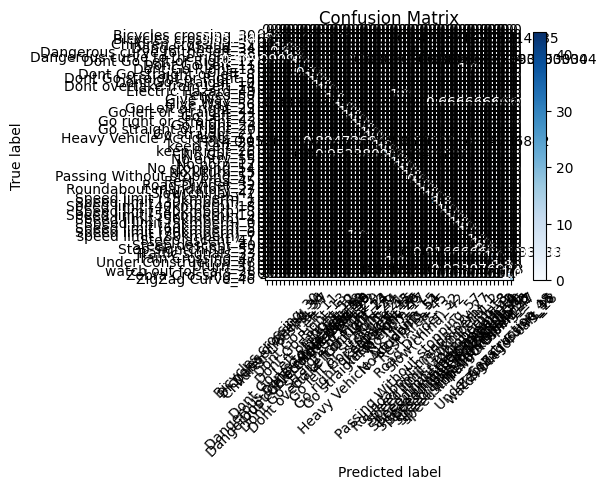

In [106]:
cm_plot_labels = os.listdir(test_dir)
plot_confusion_matrix(cm=cm,normalize=True, classes=cm_plot_labels, title='Confusion Matrix')